In [2]:
pip install tensorflow==2.5.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras==2.4.3

In [1]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [6]:
now = datetime.now()

before = now - relativedelta(years=10)

now_day = now.strftime("%Y-%m-%d")
before_day = before.strftime("%Y-%m-%d")
print(f"end: {now_day}")
print(f"start: {before_day}")

naver_stock = pdr.get_data_yahoo("035420.KS", start = before_day, end = now_day)
print(naver_stock)

end: 2022-11-06
start: 2012-11-06
[*********************100%***********************]  1 of 1 completed
                     Open           High  ...      Adj Close   Volume
Date                                      ...                        
2012-11-06   62511.796875   63002.082031  ...   61016.929688   613838
2012-11-07   62511.796875   63737.515625  ...   60777.183594   780299
2012-11-08   62756.941406   64227.804688  ...   62335.562500  1602782
2012-11-09   63492.371094   63737.515625  ...   61016.929688  1001777
2012-11-12   63124.656250   63247.226562  ...   61616.308594   704895
...                   ...            ...  ...            ...      ...
2022-10-31  163500.000000  170500.000000  ...  169500.000000  1585289
2022-11-01  168000.000000  171000.000000  ...  170500.000000   768757
2022-11-02  170000.000000  177000.000000  ...  174000.000000  1585072
2022-11-03  168500.000000  170500.000000  ...  169000.000000  1017930
2022-11-04  167500.000000  174500.000000  ...  174000.000

In [7]:
close_prices = naver_stock['Close'].values
print(close_prices)

windown_size = 30

result_list = []
for i in range(len(close_prices)-(windown_size + 1)):
    result_list.append(close_prices[i: i + (windown_size +1)])

normal_data = []
for window in result_list:
    window_list = [((float(p)/float(window[0]))-1) for p in window]
    normal_data.append(window_list)

result_list = np.array(normal_data)
print(result_list.shape[0], result_list.shape[1])



[ 62389.22265625  62144.078125    63737.515625   ... 174000.
 169000.         174000.        ]
2425 31


In [8]:
row = int(round(result_list.shape[0] * 0.9))
train = result_list[:row, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result_list[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result_list[row:, -1]

x_train.shape, x_test.shape



((2182, 30, 1), (243, 30, 1))

주식 예측 모델 구성

In [10]:
model= Sequential()
model.add(LSTM(windown_size, return_sequences=True, input_shape=(windown_size, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24320     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(x_train, y_train,
            validation_data=(x_test, y_test),
            batch_size = 10,
            epochs=10)

model.save(r'C:\파이썬과 40개의 작품들\39. 주식 예측하기\naver.h5')


Epoch 1/10
219/219 [==============================] - 3s 13ms/step - loss: 8.5197e-04 - val_loss: 4.1644e-04
Epoch 2/10
219/219 [==============================] - 3s 12ms/step - loss: 8.3918e-04 - val_loss: 5.0882e-04
Epoch 3/10
219/219 [==============================] - 3s 12ms/step - loss: 8.4779e-04 - val_loss: 6.4720e-04
Epoch 4/10
219/219 [==============================] - 3s 12ms/step - loss: 8.4362e-04 - val_loss: 4.6733e-04
Epoch 5/10
219/219 [==============================] - 3s 12ms/step - loss: 8.3507e-04 - val_loss: 4.7768e-04
Epoch 6/10
219/219 [==============================] - 3s 12ms/step - loss: 8.4080e-04 - val_loss: 4.0802e-04
Epoch 7/10
219/219 [==============================] - 3s 12ms/step - loss: 8.3498e-04 - val_loss: 4.6550e-04
Epoch 8/10
219/219 [==============================] - 3s 12ms/step - loss: 8.4465e-04 - val_loss: 4.2511e-04
Epoch 9/10
219/219 [==============================] - 3s 12ms/step - loss: 8.2186e-04 - val_loss: 4.1591e-04
Epoch 10/10
219/219

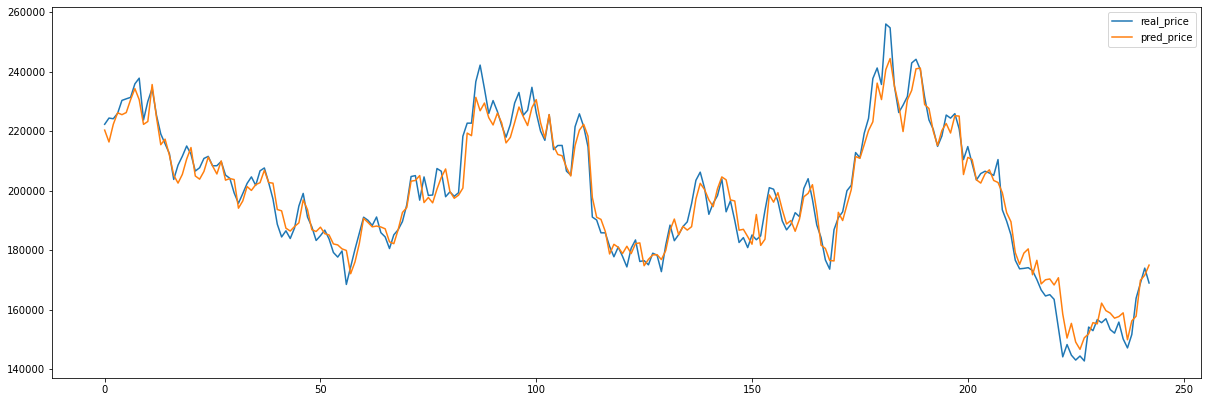

In [13]:
pred = model.predict(x_test)

pred_price = []
for i in pred:
    pred_price.append( (i + 1) * window[0] )

real_price = []
for i in y_test:
    real_price.append( (i + 1) * window[0])

fig = plt.figure(facecolor = 'white', figsize=(70, 15))
ax = fig.add_subplot(234)
ax.plot(real_price, label='real_price')
ax.plot(pred_price, label='pred_price')
ax.legend()
plt.show()